In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import astropy.constants as const
import os, sys, time
import astropy.units as u
from fractions import Fraction

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

# Directory Names

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise_v4 as SnN_v4
import SNRcalc_v4 as SNc_v4

#Save suffix for SNR and Sample data files
save_version = '_4.dat'

In [5]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

# Constants and Initial Parameters

In [6]:
'''
NOT REALLY YET.
    Variables: 
        GLOBAL:
            'T_obs' - Observation Time
        SOURCE:
            'M' - Mass (Solar Units)
            'q' - Mass Ratio
            'chi1' - Spin1
            'chi2' - Spin2
            'z' - Redshift
        LISA ONLY:
            'L' - Armlength
            'A_acc' - Acceleration Noise
            'A_IMS' - Optical Metrology
            'f_acc_break_low'
            'f_acc_break_high'
            'f_IMS_break'
        PTAs ONLY:
            'N_p' - Number of Pulsars
            'sigma' - Timing Error RMS
            'cadence' - cadence
'''

var_y = 'z' #Variable on y-axis

sampleRate_y = 100 #Number of SNRMatrix rows

var_x = 'M' #Variable on x-axis

sampleRate_x = 100 #Number of SNRMatrix columns

In [7]:
#Selects which noise curve:
#							0 is Einstein Telescope, 
#							1 is aLIGO, 
#							2 is NANOGrav 15yr,
#							3 is SKA (2030s),
#							4 is Neil Cornish's,
#							anything else is the L3 proposal

# Source Selection

In [8]:
def Get_Source(model):
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    #Doesn't Really work yet
    inc = 0.0
    inc_min = 0.0
    inc_max = 0.0
    
    source = SnN_v4.BlackHoleBinary(M,q,chi1,chi2,z,inc)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]
    source.inc = [inc,inc_min,inc_max]

    return source

# Model Selection

In [9]:
def Get_Instrument(model):
    if model == 0: #Einstein Telescope
        SNR_save_name = 'ET_SNR_Matrix' + save_version
        Sample_save_name = 'ET_Samples' + save_version
        save_location = load_directory + 'EinsteinTelescope/SNRFiles/'
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        instrument = SnN_v4.GroundBased('ET',load_location,T_obs)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 1: #aLIGO
        SNR_save_name = 'aLIGO_SNR_Matrix' + save_version
        Sample_save_name = 'aLIGO_Samples' + save_version
        save_location = load_directory + 'aLIGO/SNRFiles/'
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = SnN_v4.GroundBased('aLIGO',load_location,T_obs)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 2: #NANOGrav 15 yr

        SNR_save_name = 'NANOGrav_SNR_Matrix' + save_version
        Sample_save_name = 'NANOGrav_Samples' + save_version
        save_location = load_directory + 'NANOGrav/SNRFiles/'

        ###############################################
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        
        N_p = 18 #Number of pulsars
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        
        instrument = SnN_v4.PTA('NANOGrav',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

        
    elif model == 3: #SKA (2030s)

        SNR_save_name = 'SKA_SNR_Matrix' + save_version
        Sample_save_name = 'SKA_Samples' + save_version
        save_location = load_directory + 'SKA/SNRFiles/'

        ###############################################
        #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        
        N_p = 20 #Number of pulsars
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        
        instrument = SnN_v4.PTA('SKA',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        
    elif model == 4: #Robson,Cornish,and Liu 2018, LISA (https://arxiv.org/pdf/1803.01944.pdf)
        SNR_save_name = 'LISA_Neil_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_Neil_Samples' + save_version
        save_location = load_directory + 'LISA_Neil/SNRFiles/'
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
          
        A_acc = 3e-15*u.m/u.s/u.s #M/s**2
        A_IMS = 1.5e-11*u.m
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        Background = False
        
        instrument = SnN_v4.SpaceBased('Neil_LISA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        
    else: #L3 proposal
        SNR_save_name = 'LISA_ESA_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_ESA_Samples' + save_version
        save_location = load_directory + 'LISA_ESA/SNRFiles/'

        #Default Params!
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        
        instrument = SnN_v4.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        
    return [instrument,SNR_save_name,Sample_save_name,save_location]

# Setting Up SNR Calculation
Uses the variables given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


In [11]:
model = 5
[instrument,SNR_save_name,Sample_save_name,save_location] = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = SNc_v4.getSNRMatrix(source,instrument,\
                                                 var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

/home/andrew/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [ ]:
figname = '/LISA_Lvq.pdf'
isitsavetime = False
if isitsavetime:
    figloc = fig_save_location + figname
else:
    figloc = None
SNc_v4.plotSNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,figloc=figloc,smooth_contours=False)

# Whole Hog Creation of SNR Matrices and Samples

/home/andrew/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


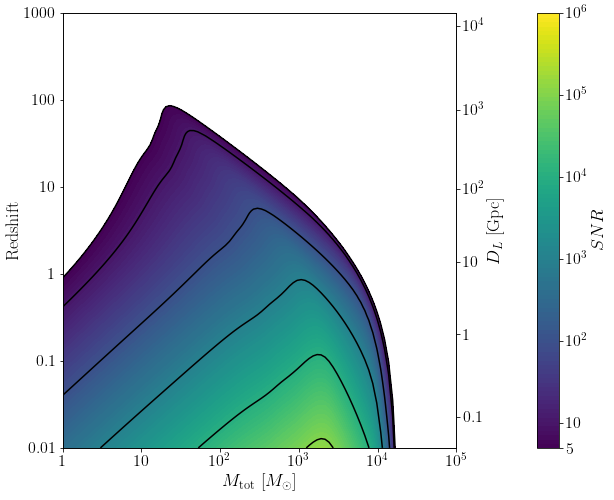

Model:  ET ,  done. t = :  35.64240622520447


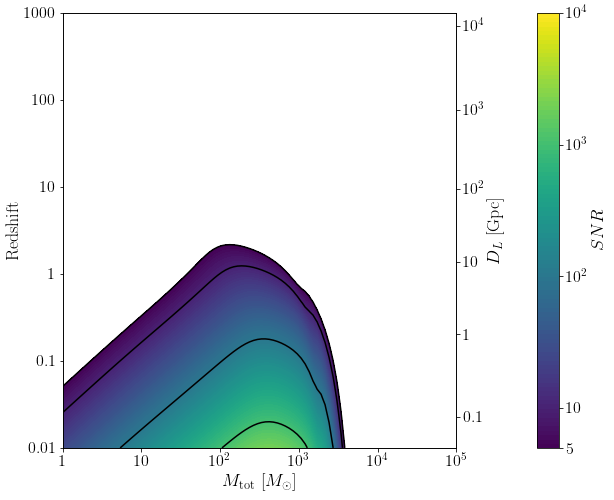

Model:  aLIGO ,  done. t = :  36.018051862716675


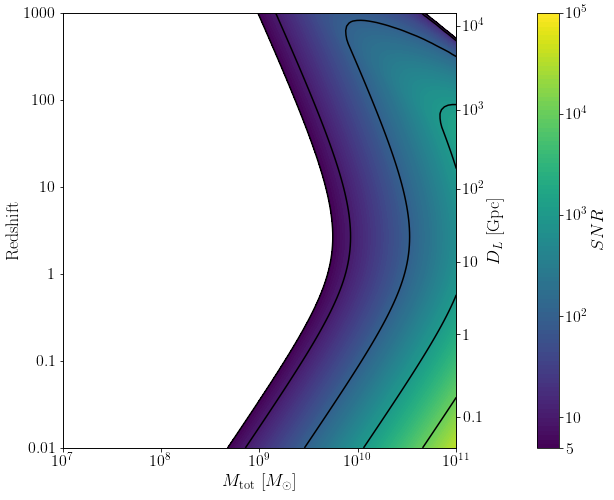

Model:  NANOGrav ,  done. t = :  26.478841066360474


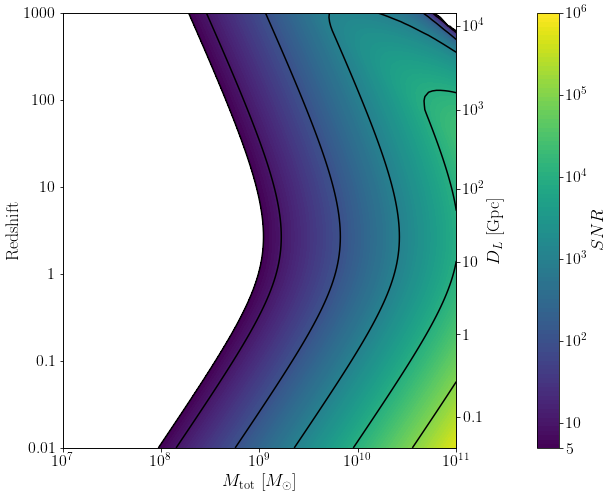

Model:  SKA ,  done. t = :  29.706416606903076


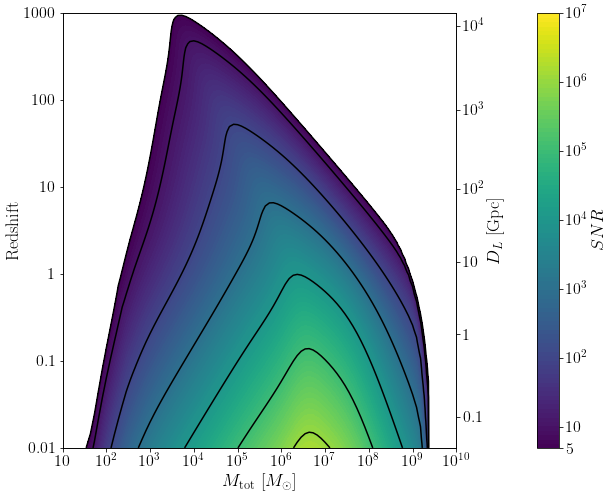

Model:  LISA_ESA ,  done. t = :  40.60558199882507


In [13]:
models = [0,1,2,3,5]
for model in models:
    [instrument,SNR_save_name,Sample_save_name,save_location] = Get_Instrument(model)
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = SNc_v4.getSNRMatrix(source,instrument,\
                                             var_x,sampleRate_x,var_y,sampleRate_y)
    end = time.time()
    #SNc_v4.saveSNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    SNc_v4.plotSNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,dl_axis=True,smooth_contours=True)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)
    '''cont = input('continue? ')
    if cont == 'y':
        pass
    else:
        break'''